In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from joblib import Parallel, delayed
import os

import sys
sys.path.append(os.environ['GORDON_REPO_DIR'] + '/pipeline_scripts')
from utilities2014 import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=1)
dm._load_image()

textonmap = dm.load_pipeline_result('texMap', 'npy')
textonmap_viz = dm.load_pipeline_result('texMap', 'png')
n_texton = len(np.unique(textonmap)) - 1

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [3]:
mys, mxs = np.where(dm.mask)
mys = mys.astype(np.int16)
mxs = mxs.astype(np.int16)

n_theta = 12
theta_binwidth = 2*np.pi/n_theta

radius_list = [50,100,200]
n_radius = len(radius_list)
max_radius = radius_list[-1]

In [5]:
box_indices = np.dstack(np.meshgrid(np.arange(-max_radius, max_radius+1), 
                                    np.arange(-max_radius, max_radius+1))).astype(np.int16)
norms = np.linalg.norm(box_indices.astype(np.float), axis=-1)

pie_indices_r = []
circle_indices_r = []

for ri in range(n_radius):
    circle_indices = box_indices[norms <= radius_list[ri]]
    circle_indices_r.append(circle_indices)
    
    angles = np.arctan2(circle_indices[:,0], circle_indices[:,1])
    angles[angles < 0] += 2*np.pi
    angular_bins = np.int0(angles/theta_binwidth)
    pie_indices = [circle_indices[angular_bins==k] for k in range(n_theta)]
    pie_indices_r.append(pie_indices)
    
pie_mask = [[None for _ in range(n_theta)] for _ in radius_list]
for ri, r in enumerate(radius_list):
    for s in range(n_theta):
        pie_mask[ri][s] = np.zeros((2*r+1,2*r+1), np.bool).copy()
        pie_mask[ri][s][r+pie_indices_r[ri][s][:,0], r+pie_indices_r[ri][s][:,1]] = 1

In [8]:
from scipy.signal import fftconvolve

textonmap_individual_channels = [textonmap == c for c in range(n_texton)]

def compute_pie_histogram(pie_mask, ri, s):
    
    # notice the data type is set to uint16 here!
    h = np.zeros((dm.image_height, dm.image_width, n_texton), np.uint16)
    for c in range(n_texton):
        h[:,:,c] = fftconvolve(textonmap_individual_channels[c], pie_mask, mode='same').astype(np.uint16)
        
    dm.save_pipeline_result(h, 'histRadius%dAngle%d'%(ri,s), 'hdf')
    

In [9]:
for ri in range(n_radius):
    t = time.time()
    # roughly 40s
    Parallel(n_jobs=16)(delayed(compute_pie_histogram)(pie_mask[ri][s], ri, s) for s in range(n_theta))
    print time.time() - t

39.6645328999
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_histRadius0Angle1.hdf
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_histRadius0Angle0.hdf
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_histRadius0Angle2.hdf
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_histRadius0Angle9.hdf
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_histRadius0Angle3.hdf
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_histRadius0Angle4.hdf
sa

In [15]:
t = time.time()

H = np.zeros((n_radius, n_theta, dm.image_height, dm.image_width, n_texton), np.uint16)
for ri in range(n_radius):

# def load(ri,s):
#     return dm.load_pipeline_result('histRadius%dAngle%d'%(ri,s), 'hdf')
# H = Parallel(n_jobs=16)(delayed(load)(ri, s) for s in range(n_theta/2))
# H = np.asarray(H)

    for s in range(n_theta):
        H[ri, s] = dm.load_pipeline_result('histRadius%dAngle%d'%(ri,s), 'hdf')
print time.time() - t

32.2897090912


In [16]:
def compute_halfdisc_histogram_diff(H, start_bin, mys, mxs, r):
    
    n_theta, height, width = H.shape[1:4]
    
    Gs = np.zeros((height, width), np.float)

    first_half_bins = np.arange(start_bin, start_bin+n_theta/2)%n_theta
    second_half_bins = np.arange(start_bin+n_theta/2, start_bin+n_theta)%n_theta

    H_halfdisk1 = np.sum(H[r, first_half_bins[:,None], mys, mxs], axis=0).astype(np.float)
    H_halfdisk2 = np.sum(H[r, second_half_bins[:,None], mys, mxs], axis=0).astype(np.float)
        
    H_halfdisk1 /= H_halfdisk1.sum(axis=-1)[:,None]
    H_halfdisk2 /= H_halfdisk2.sum(axis=-1)[:,None]
    
    Gs[mys, mxs] = chi2s(H_halfdisk1, H_halfdisk2)
    
    dm.save_pipeline_result(Gs, 'GmaxRadius%dAngle%d'%(r, start_bin), 'npy')
    
    # return or not does not affect performance at all
    return Gs

In [18]:
Gmax = np.zeros((dm.image_height, dm.image_width))

for ri in range(n_radius):
#     ri = 0

    t = time.time()

    # G = Parallel(n_jobs=16, max_nbytes=None)(delayed(compute_halfdisc_histogram_diff)(s, mys, mxs) for s in range(n_theta/2))
    # parallel causes thrashing

    # G = [compute_halfdisc_histogram_diff(s, mys, mxs) for s in range(n_theta/2)]
    # almost the same speed as passing in H
    # not passing in mys and mxs is significantly slower

    G = [compute_halfdisc_histogram_diff(H, s, mys, mxs, ri) for s in range(n_theta/2)]

    Gmax_r = np.max(G, axis=0)
    Gmax = np.maximum(Gmax_r, Gmax)
    
    print time.time() - t

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide


saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_GmaxRadius0Angle0.npy
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_GmaxRadius0Angle1.npy
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_GmaxRadius0Angle2.npy
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_GmaxRadius0Angle3.npy
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_GmaxRadius0Angle4.npy
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_GmaxRadius0Angle5.npy
80.9069058895
sa

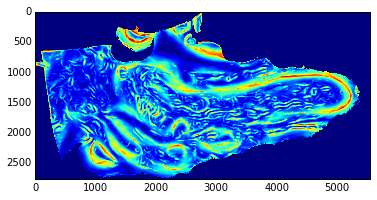

In [32]:
plt.imshow(Gmax)